# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

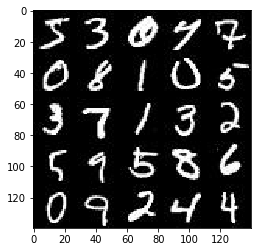

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

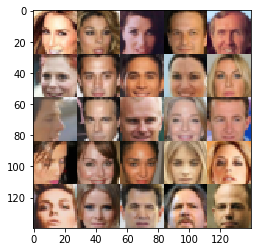

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # input images, z input & learning rate placehoders
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32)

    # return tuple of inputs real, inputs z & learning rate
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # leaky ReLU slope for x < 0 & prob for dropout
    alpha = 0.2
    keep_prob = 0.8
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Layer 1 (Input 28x28x3): convolution, leaky ReLU
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        
        # Layer 2 (Input 14x14x64): convolution, batch normalization, leaky ReLU
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True) # change training value for inference
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        # Layer 3 (Input 7x7x128): convolution, batch normalization, leaky ReLU
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True) # change training value for inference
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)

        # Flatten (Input 4x4x256): flatten, logits, output
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        # return output & logits
        return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # leaky ReLU slope for x < 0 & prob for dropout
    alpha = 0.2
    keep_prob = 0.5
    
    # reuse variables when it is not training
    with tf.variable_scope('generator', reuse=not is_train):
        
        # FC Layer
        f1 = tf.layers.dense(z, 7*7*512)
        f1 = tf.reshape(f1, (-1, 7, 7, 512))
        f1 = tf.layers.batch_normalization(f1, training=is_train)
        f1 = tf.maximum(alpha * f1, f1)
        
        # Layer 1 (Input 7x7x512): reshape, batch normalization, leaky ReLU, dropout
        x1 = tf.layers.conv2d_transpose(f1, 256, 5, strides=1, padding='SAME')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        
        # Layer 2 (Input 7x7x256): convolution, batch normalization, leaky ReLU, dropout
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        # Layer 3 (Input 14x14x128): convolution, batch normalization, leaky ReLU, dropout
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=1, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        # Layer 3 (Input 14x14x64): convolution, batch normalization, leaky ReLU, dropout
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same') 
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        
        # Output Layer (Input 14x14x32)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='SAME')
        
        # Output
        output = tf.tanh(logits)
        
        # return output
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # generator model
    g_model = generator(input_z, out_channel_dim)
    
    # discriminator models
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # discriminator loss using sigmoid cross entropy
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9)) # smoothing
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss using sigmoid cross entropy
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    # return tuple of d_loss & g_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # filter the variables with the scope names
    t_v = tf.trainable_variables()
    d_variables = [v for v in t_v if v.name.startswith('discriminator')]
    g_variables = [v for v in t_v if v.name.startswith('generator')]

    # optimize using adam & minimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_variables)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_variables)

    # return tuple of discriminator & generator training optimization
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # create placehoders, calculate loss, optimize model
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    output_channel = 3 if data_image_mode=="RGB" else 1

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0

                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers (run generator optimizer twice)
                _ = sess.run(d_opt, feed_dict={input_z: batch_z,
                                               input_real: batch_images,
                                               learn_rate: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z,
                                               input_real: batch_images, 
                                               learn_rate: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z,
                                               input_real: batch_images, 
                                               learn_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real:batch_images})
                    
                    train_loss_g = g_loss.eval({input_z: batch_z, 
                                                input_real:batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 50 == 0:
                    show_generator_output(sess, 20, input_z, output_channel, data_image_mode)



### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3737... Generator Loss: 0.6803
Epoch 1/2... Discriminator Loss: 1.4707... Generator Loss: 0.7603
Epoch 1/2... Discriminator Loss: 1.6029... Generator Loss: 2.5996
Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 1.9614
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 3.5058


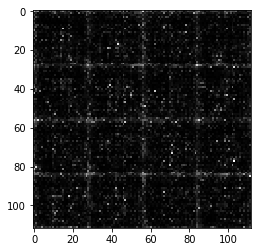

Epoch 1/2... Discriminator Loss: 1.5803... Generator Loss: 1.3367
Epoch 1/2... Discriminator Loss: 1.6300... Generator Loss: 0.6204
Epoch 1/2... Discriminator Loss: 1.5734... Generator Loss: 1.6406
Epoch 1/2... Discriminator Loss: 1.5748... Generator Loss: 0.9822
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.9351


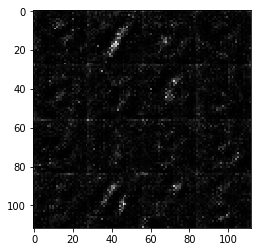

Epoch 1/2... Discriminator Loss: 1.6438... Generator Loss: 1.0681
Epoch 1/2... Discriminator Loss: 1.5094... Generator Loss: 1.1125
Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 0.9115
Epoch 1/2... Discriminator Loss: 1.8111... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 1.8806... Generator Loss: 1.0242


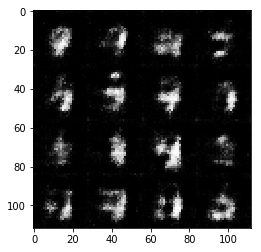

Epoch 1/2... Discriminator Loss: 1.7398... Generator Loss: 0.7584
Epoch 1/2... Discriminator Loss: 1.6775... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.9216
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 1.0961
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 0.6824


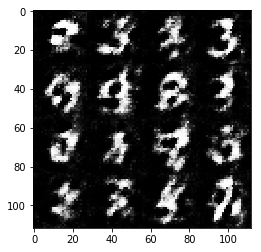

Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.8365
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 1.1624
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 1.6068... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.9758


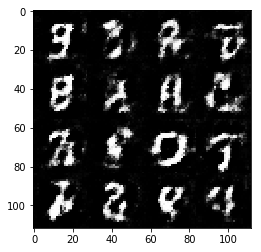

Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 0.9846
Epoch 1/2... Discriminator Loss: 1.6793... Generator Loss: 0.6556
Epoch 1/2... Discriminator Loss: 1.4661... Generator Loss: 0.8979
Epoch 1/2... Discriminator Loss: 1.2913... Generator Loss: 1.0041
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 1.0816


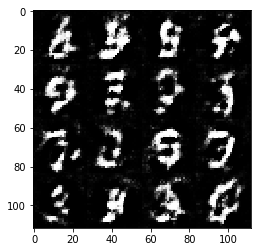

Epoch 1/2... Discriminator Loss: 1.3408... Generator Loss: 1.0918
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.8590
Epoch 1/2... Discriminator Loss: 1.4223... Generator Loss: 1.2010
Epoch 1/2... Discriminator Loss: 1.4886... Generator Loss: 0.8058
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 1.0132


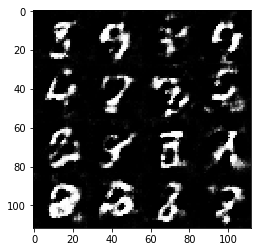

Epoch 1/2... Discriminator Loss: 1.2896... Generator Loss: 0.8551
Epoch 1/2... Discriminator Loss: 1.4110... Generator Loss: 1.0167
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 0.9630


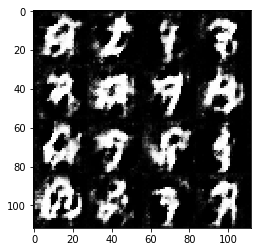

Epoch 1/2... Discriminator Loss: 1.8676... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 1.0522... Generator Loss: 1.3314
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.8774
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 1.1596... Generator Loss: 1.2942


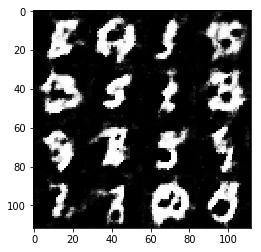

Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 1.0276
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 1.1992
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 1.1512
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 1.4783
Epoch 1/2... Discriminator Loss: 1.4806... Generator Loss: 0.6870


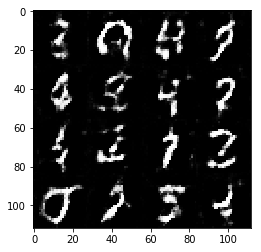

Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 1.1173
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 0.9009
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.3802... Generator Loss: 0.8415


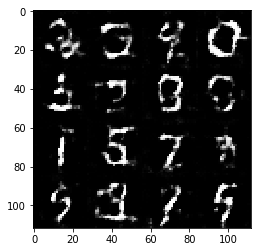

Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 0.9801
Epoch 1/2... Discriminator Loss: 1.2700... Generator Loss: 0.7410
Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 1.1491
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 1.1176
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 1.2284


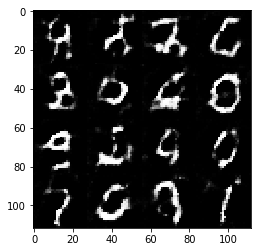

Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 0.7515
Epoch 1/2... Discriminator Loss: 1.3612... Generator Loss: 0.8678
Epoch 1/2... Discriminator Loss: 1.2966... Generator Loss: 0.8852
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 0.8901
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.8079


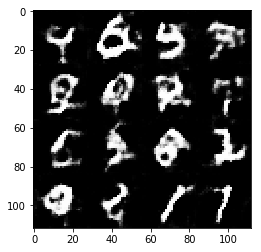

Epoch 1/2... Discriminator Loss: 1.2606... Generator Loss: 1.1179
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.9969
Epoch 1/2... Discriminator Loss: 1.1889... Generator Loss: 1.2164
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.7795


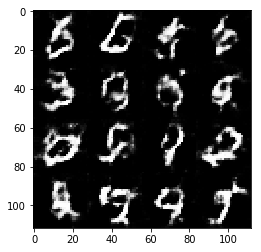

Epoch 1/2... Discriminator Loss: 1.6890... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 1.0804
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 1.1187
Epoch 1/2... Discriminator Loss: 1.2952... Generator Loss: 0.9508
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 1.3193


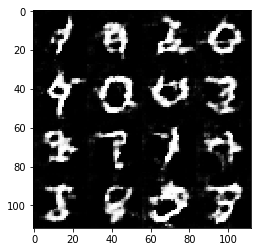

Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 1.6038
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 1.0859
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 1.0336
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 1.0219
Epoch 1/2... Discriminator Loss: 1.6314... Generator Loss: 0.5791


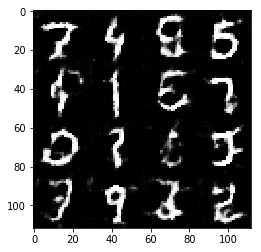

Epoch 1/2... Discriminator Loss: 1.1260... Generator Loss: 0.8822
Epoch 1/2... Discriminator Loss: 1.5010... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 1.3491
Epoch 1/2... Discriminator Loss: 1.7063... Generator Loss: 0.6539


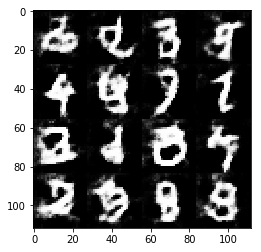

Epoch 1/2... Discriminator Loss: 1.3670... Generator Loss: 1.1468
Epoch 1/2... Discriminator Loss: 1.3644... Generator Loss: 0.8748
Epoch 1/2... Discriminator Loss: 1.5049... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 1.2875... Generator Loss: 0.9450
Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.8857


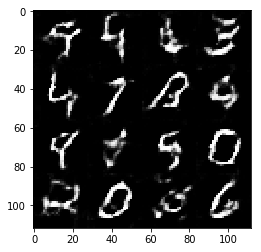

Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 1.4159... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 1.0719


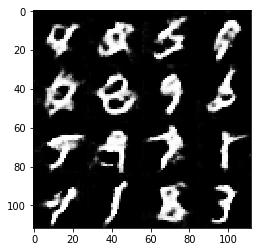

Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 1.2518
Epoch 1/2... Discriminator Loss: 1.4806... Generator Loss: 0.6469
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 1.1850
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.9831


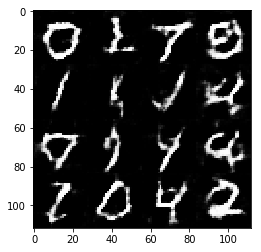

Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 1.1920
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 1.0431
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 1.0422


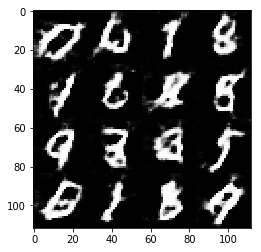

Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.9741
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 0.8685
Epoch 1/2... Discriminator Loss: 1.1231... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 1.5575... Generator Loss: 0.6862


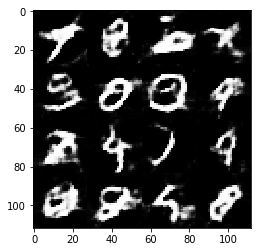

Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.6918
Epoch 1/2... Discriminator Loss: 1.3487... Generator Loss: 0.7166
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 1.0557
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.9390


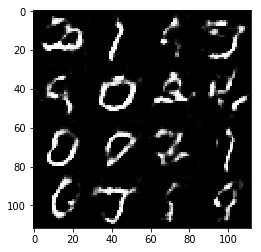

Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 1.1071
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.9521
Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 1.1278
Epoch 1/2... Discriminator Loss: 1.2860... Generator Loss: 1.0352
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 1.0701


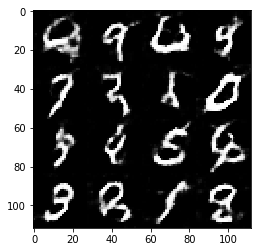

Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.9354
Epoch 1/2... Discriminator Loss: 1.3292... Generator Loss: 0.9283
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 1.0200
Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 1.0325


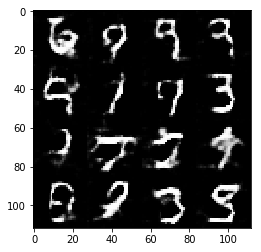

Epoch 1/2... Discriminator Loss: 1.2766... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 1.2923... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.9488
Epoch 1/2... Discriminator Loss: 1.4918... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 1.1465


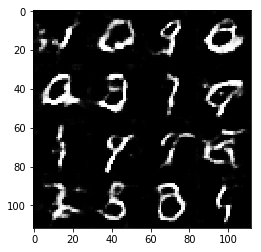

Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 1.1694
Epoch 1/2... Discriminator Loss: 1.3451... Generator Loss: 0.9775
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 1.2620... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.8624


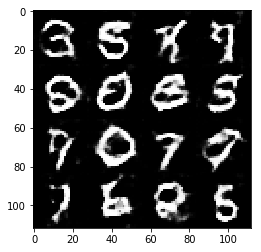

Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.7811
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 1.1279
Epoch 1/2... Discriminator Loss: 1.2596... Generator Loss: 0.7451
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 0.7427


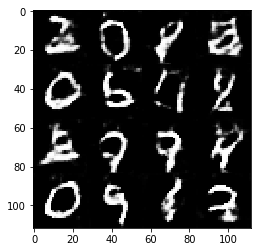

Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 1.1615
Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 0.9469
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 1.1994
Epoch 1/2... Discriminator Loss: 1.1013... Generator Loss: 1.1018


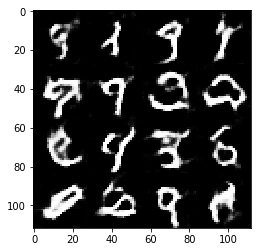

Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.8389
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.8004
Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 0.9982
Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 1.0345


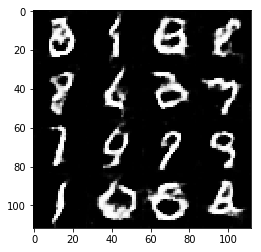

Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 0.9071
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 1.0604
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 0.8830
Epoch 1/2... Discriminator Loss: 1.4311... Generator Loss: 0.7749


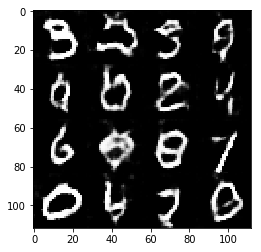

Epoch 1/2... Discriminator Loss: 1.2845... Generator Loss: 1.1008
Epoch 1/2... Discriminator Loss: 1.1706... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.2321... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.9705


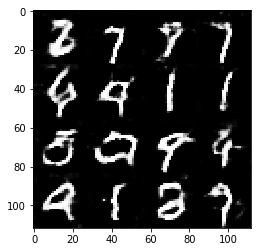

Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 0.9814
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.8235
Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 0.9740
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 1.2614
Epoch 1/2... Discriminator Loss: 1.0869... Generator Loss: 1.5526


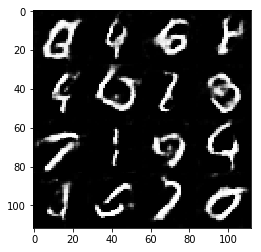

Epoch 1/2... Discriminator Loss: 1.1962... Generator Loss: 0.8984
Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 1.2610
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 1.2329
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 1.0157
Epoch 1/2... Discriminator Loss: 1.1537... Generator Loss: 0.9507


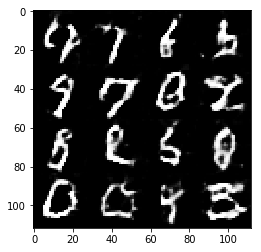

Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 1.2513
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 1.1402
Epoch 1/2... Discriminator Loss: 1.3188... Generator Loss: 0.9897
Epoch 1/2... Discriminator Loss: 1.4167... Generator Loss: 1.1080


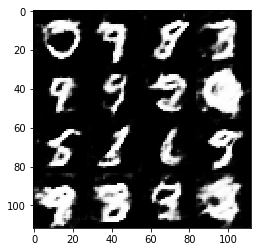

Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 1.0097
Epoch 1/2... Discriminator Loss: 1.2588... Generator Loss: 1.0079
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 1.0839
Epoch 1/2... Discriminator Loss: 1.0483... Generator Loss: 1.2757
Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 0.8921


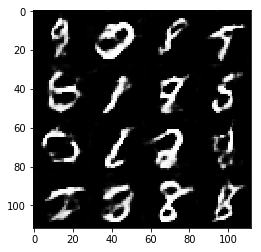

Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 0.9103
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 1.1066
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.8756
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 1.1148
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.8018


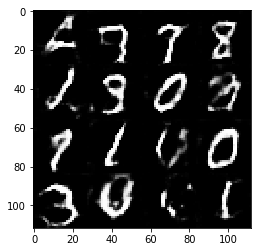

Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 0.8749
Epoch 2/2... Discriminator Loss: 1.2438... Generator Loss: 1.0004
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 1.1726


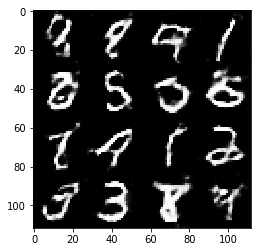

Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 0.9206
Epoch 2/2... Discriminator Loss: 1.2857... Generator Loss: 0.8664
Epoch 2/2... Discriminator Loss: 1.4300... Generator Loss: 0.7311
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.8751
Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 0.9137


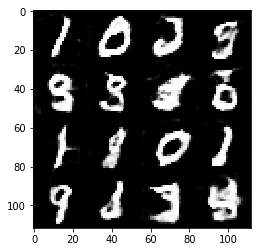

Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 1.2474
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.2825... Generator Loss: 1.1324
Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 1.4694
Epoch 2/2... Discriminator Loss: 1.1395... Generator Loss: 1.1398


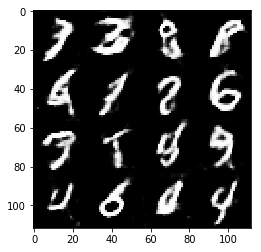

Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.1285... Generator Loss: 1.1109
Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.1038... Generator Loss: 0.9874
Epoch 2/2... Discriminator Loss: 1.1894... Generator Loss: 1.1165


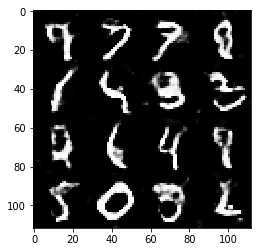

Epoch 2/2... Discriminator Loss: 1.1188... Generator Loss: 1.2497
Epoch 2/2... Discriminator Loss: 1.0998... Generator Loss: 0.8719
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 1.0613... Generator Loss: 0.9010
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 1.2806


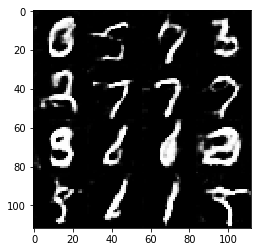

Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 1.1089
Epoch 2/2... Discriminator Loss: 1.2084... Generator Loss: 0.9649
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 1.1310
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 1.3529
Epoch 2/2... Discriminator Loss: 1.3383... Generator Loss: 0.9296


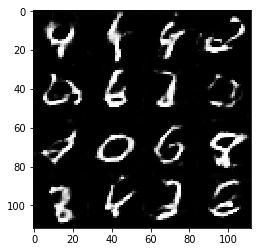

Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 1.2500
Epoch 2/2... Discriminator Loss: 1.1399... Generator Loss: 0.9909
Epoch 2/2... Discriminator Loss: 1.0492... Generator Loss: 1.1518
Epoch 2/2... Discriminator Loss: 1.0510... Generator Loss: 1.1642


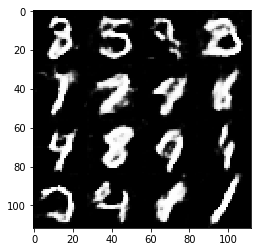

Epoch 2/2... Discriminator Loss: 1.1389... Generator Loss: 1.1514
Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 1.2705
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 1.0464
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 0.9691
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.9459


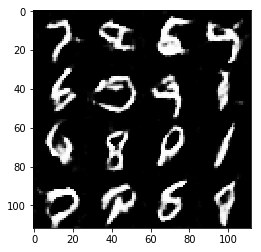

Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 1.2465
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 1.3672
Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.7595
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.2004... Generator Loss: 1.1856


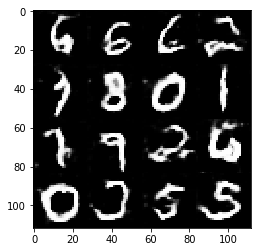

Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 1.5184... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 1.0107
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.9860
Epoch 2/2... Discriminator Loss: 1.0551... Generator Loss: 1.0686


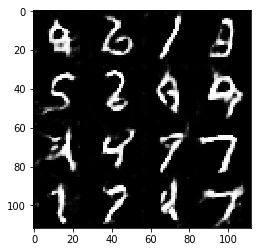

Epoch 2/2... Discriminator Loss: 1.1978... Generator Loss: 1.1245
Epoch 2/2... Discriminator Loss: 1.1918... Generator Loss: 1.1949
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.1339... Generator Loss: 1.3770
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 1.2438


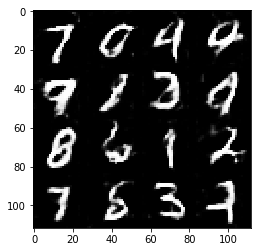

Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 1.1649
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 1.7258
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 1.4945
Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 1.1004


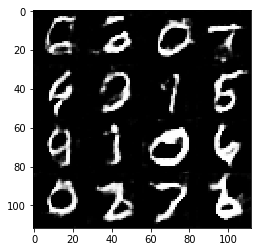

Epoch 2/2... Discriminator Loss: 0.9983... Generator Loss: 1.3263
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 1.2696
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.7355
Epoch 2/2... Discriminator Loss: 1.0463... Generator Loss: 1.3949
Epoch 2/2... Discriminator Loss: 1.2629... Generator Loss: 0.9186


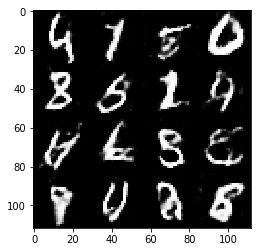

Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 1.1194
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 1.4604
Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 1.2065... Generator Loss: 1.0825
Epoch 2/2... Discriminator Loss: 1.3667... Generator Loss: 1.0775


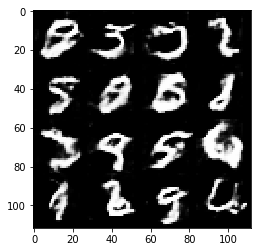

Epoch 2/2... Discriminator Loss: 1.1414... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 1.4310
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 1.0944
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 1.1135
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 1.4732


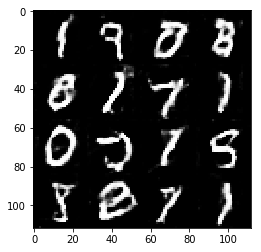

Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.9694
Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 1.0847
Epoch 2/2... Discriminator Loss: 1.0901... Generator Loss: 1.3056
Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 0.8504
Epoch 2/2... Discriminator Loss: 1.0692... Generator Loss: 1.0931


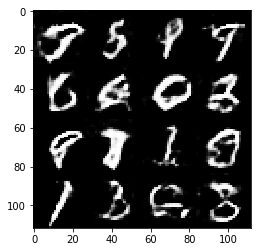

Epoch 2/2... Discriminator Loss: 1.1259... Generator Loss: 1.5266
Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 1.0403
Epoch 2/2... Discriminator Loss: 1.0756... Generator Loss: 1.5303
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 1.1365
Epoch 2/2... Discriminator Loss: 1.2530... Generator Loss: 0.8705


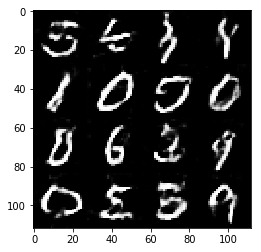

Epoch 2/2... Discriminator Loss: 1.2556... Generator Loss: 1.0623
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.9853
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.9685
Epoch 2/2... Discriminator Loss: 0.9602... Generator Loss: 1.2248
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 0.9660


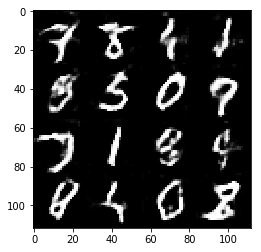

Epoch 2/2... Discriminator Loss: 1.1092... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 1.1167
Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 1.2742
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 1.5086


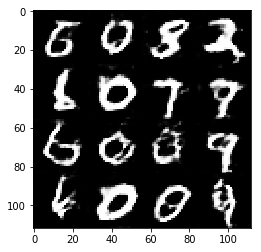

Epoch 2/2... Discriminator Loss: 1.2648... Generator Loss: 1.3726
Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 1.1278
Epoch 2/2... Discriminator Loss: 1.0731... Generator Loss: 1.5837
Epoch 2/2... Discriminator Loss: 1.1895... Generator Loss: 1.5772
Epoch 2/2... Discriminator Loss: 1.3560... Generator Loss: 0.7875


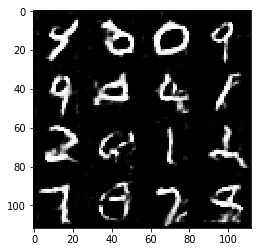

Epoch 2/2... Discriminator Loss: 1.1939... Generator Loss: 1.1112
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 1.0057
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 1.5475
Epoch 2/2... Discriminator Loss: 1.0939... Generator Loss: 1.2267
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 1.1217


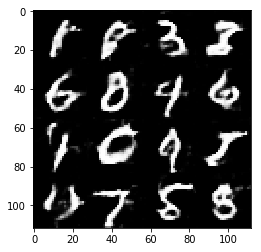

Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 1.4457
Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 1.2075
Epoch 2/2... Discriminator Loss: 0.9793... Generator Loss: 1.2174
Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 1.0037
Epoch 2/2... Discriminator Loss: 0.9697... Generator Loss: 1.2632


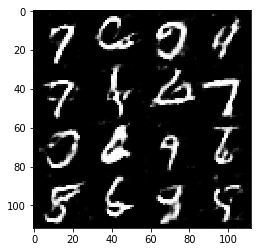

Epoch 2/2... Discriminator Loss: 1.1701... Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 1.3120
Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 1.0657
Epoch 2/2... Discriminator Loss: 1.0308... Generator Loss: 1.3689


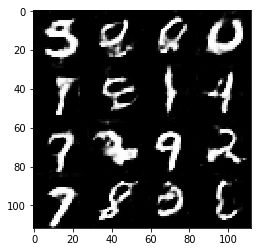

Epoch 2/2... Discriminator Loss: 1.4413... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 1.3736
Epoch 2/2... Discriminator Loss: 1.0148... Generator Loss: 1.0969
Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 1.3221
Epoch 2/2... Discriminator Loss: 1.0130... Generator Loss: 0.8881


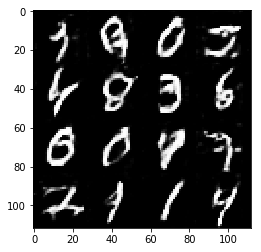

Epoch 2/2... Discriminator Loss: 0.9554... Generator Loss: 1.6097
Epoch 2/2... Discriminator Loss: 1.1388... Generator Loss: 0.9596
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 1.1891
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 1.4241
Epoch 2/2... Discriminator Loss: 1.0047... Generator Loss: 1.1623


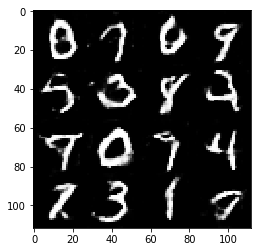

Epoch 2/2... Discriminator Loss: 1.1549... Generator Loss: 1.3250
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.2941
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 1.3481
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 0.9212
Epoch 2/2... Discriminator Loss: 1.0990... Generator Loss: 1.0433


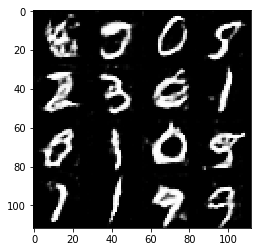

Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 1.2694
Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 1.2238
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 1.1662
Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 1.0881
Epoch 2/2... Discriminator Loss: 0.8728... Generator Loss: 1.3261


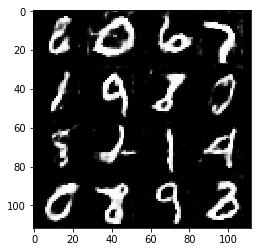

Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 1.2973
Epoch 2/2... Discriminator Loss: 1.3169... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 1.2153
Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 1.3600


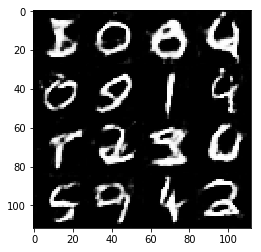

Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 1.4722
Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 1.3449
Epoch 2/2... Discriminator Loss: 0.9944... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 0.7356
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.8692


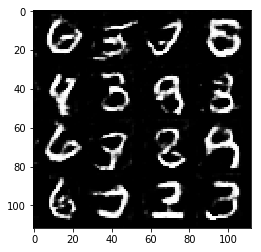

Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 1.4077
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 1.2765
Epoch 2/2... Discriminator Loss: 0.9629... Generator Loss: 1.3742
Epoch 2/2... Discriminator Loss: 0.8639... Generator Loss: 1.4252
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 1.4212


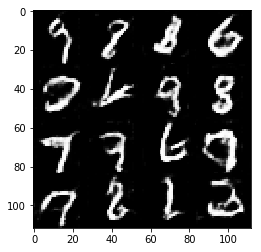

Epoch 2/2... Discriminator Loss: 1.0450... Generator Loss: 2.1997
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 0.8346
Epoch 2/2... Discriminator Loss: 1.1296... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.6650
Epoch 2/2... Discriminator Loss: 1.0792... Generator Loss: 1.4037


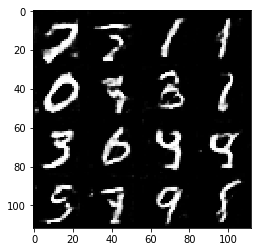

Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 0.8196
Epoch 2/2... Discriminator Loss: 0.9356... Generator Loss: 1.4582
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 1.4096
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 1.0416
Epoch 2/2... Discriminator Loss: 1.0309... Generator Loss: 0.8947


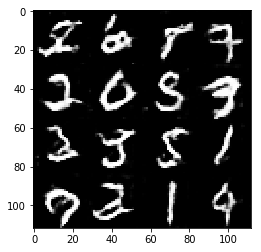

Epoch 2/2... Discriminator Loss: 1.2548... Generator Loss: 1.6853
Epoch 2/2... Discriminator Loss: 0.9046... Generator Loss: 1.2538
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 1.3919
Epoch 2/2... Discriminator Loss: 0.9739... Generator Loss: 1.8680
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 1.2076


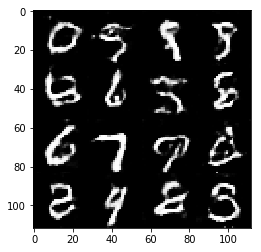

Epoch 2/2... Discriminator Loss: 1.2108... Generator Loss: 0.6323
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 1.8811
Epoch 2/2... Discriminator Loss: 0.9391... Generator Loss: 0.8710
Epoch 2/2... Discriminator Loss: 1.0405... Generator Loss: 1.1697
Epoch 2/2... Discriminator Loss: 0.8647... Generator Loss: 1.4996


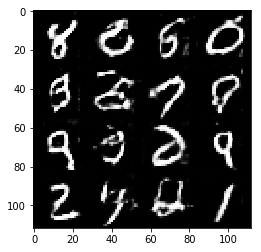

Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 1.6479
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 1.0349
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.4750
Epoch 2/2... Discriminator Loss: 1.8303... Generator Loss: 0.4087
Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 1.0148


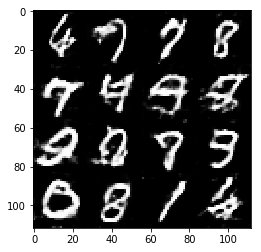

Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 1.5066
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 1.0144
Epoch 2/2... Discriminator Loss: 0.8789... Generator Loss: 1.1770
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 1.0777
Epoch 2/2... Discriminator Loss: 0.8265... Generator Loss: 1.7389


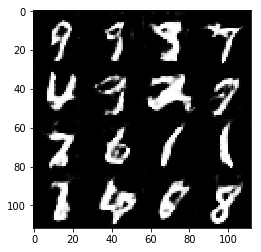

Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 1.2253
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.4420
Epoch 2/2... Discriminator Loss: 1.0084... Generator Loss: 1.3023
Epoch 2/2... Discriminator Loss: 1.0299... Generator Loss: 1.2955
Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 1.2193


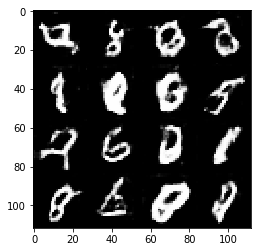

Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 1.9670
Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 1.3685
Epoch 2/2... Discriminator Loss: 0.9849... Generator Loss: 1.4541
Epoch 2/2... Discriminator Loss: 0.9228... Generator Loss: 1.5327
Epoch 2/2... Discriminator Loss: 0.9873... Generator Loss: 2.0968


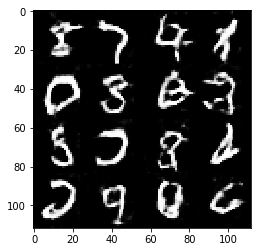

In [33]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, 
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 1.7245
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 2.7037
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.4644
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 4.1954


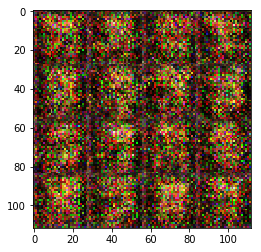

Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.3206
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.5946
Epoch 1/1... Discriminator Loss: 0.5970... Generator Loss: 2.3488
Epoch 1/1... Discriminator Loss: 0.5902... Generator Loss: 2.8911
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 2.2488


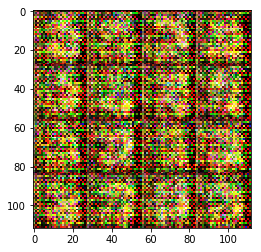

Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 2.6420
Epoch 1/1... Discriminator Loss: 0.4850... Generator Loss: 3.6945
Epoch 1/1... Discriminator Loss: 0.7284... Generator Loss: 2.2544
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 2.3553
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 4.0278


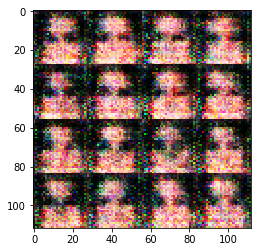

Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 3.3977
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 2.1131
Epoch 1/1... Discriminator Loss: 0.5632... Generator Loss: 2.9179
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 2.2493
Epoch 1/1... Discriminator Loss: 0.6516... Generator Loss: 2.9294


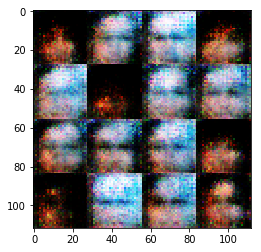

Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 3.6662
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 3.8685
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.4412
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 3.3635


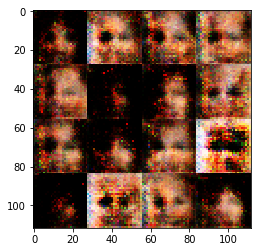

Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.6470
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 2.5084
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 2.7796
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.2237


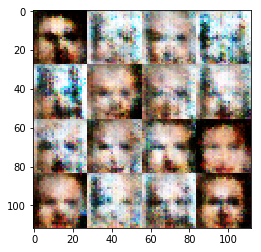

Epoch 1/1... Discriminator Loss: 0.8756... Generator Loss: 1.8367
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 3.5168
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.6557
Epoch 1/1... Discriminator Loss: 1.6758... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 0.7300... Generator Loss: 1.7724


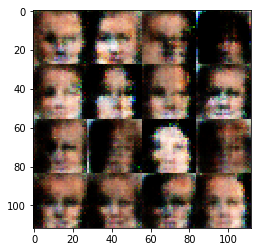

Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.3734
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.5046
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 1.4035


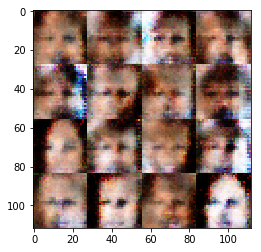

Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.9820
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.2543
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 1.6675
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.8918


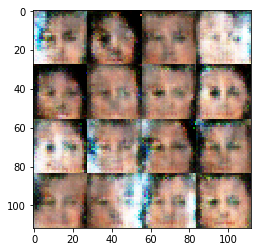

Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 1.5017
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7945


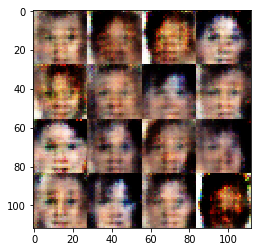

Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.7473
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.0596... Generator Loss: 1.4330


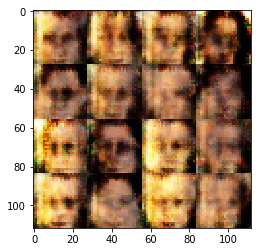

Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 1.1939


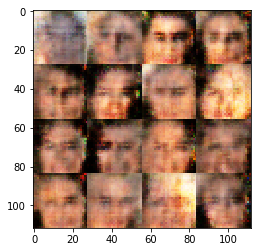

Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 1.6350... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 1.0206


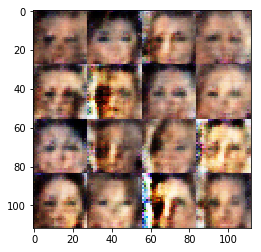

Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.3990


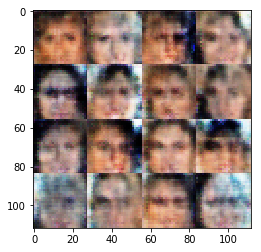

Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.8511


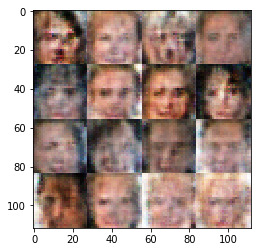

Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 1.6821... Generator Loss: 0.7355


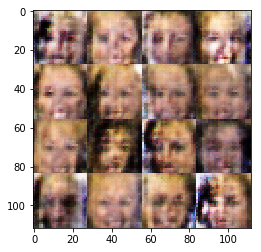

Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 1.0295
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 1.1426
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.0266


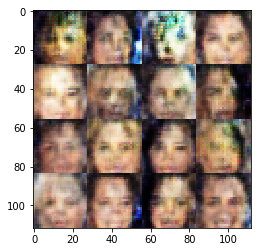

Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.7576


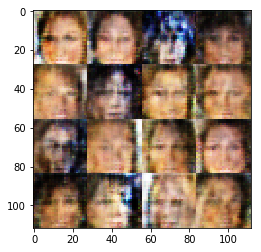

Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.9380


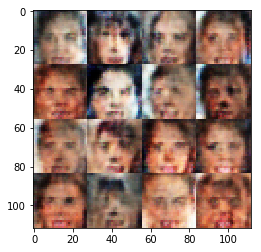

Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.1815


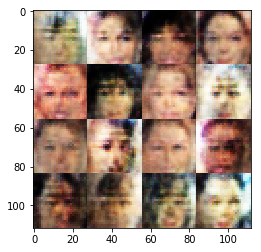

Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.6365... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.8802


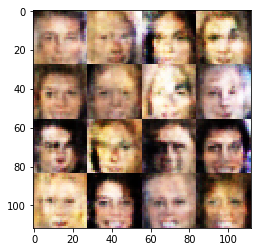

Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.7535... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.9595


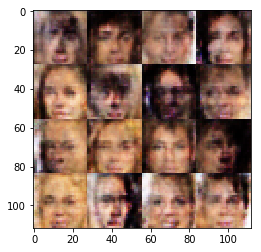

Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.7993


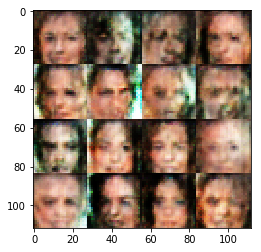

Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.9329


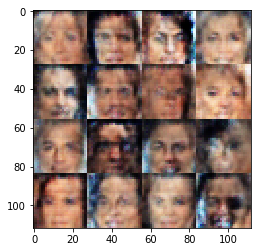

Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.7971


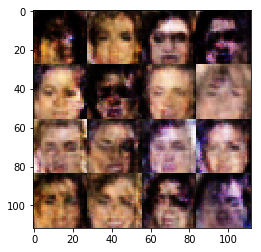

Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.9331


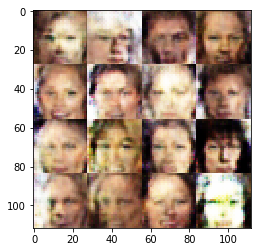

Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.8416


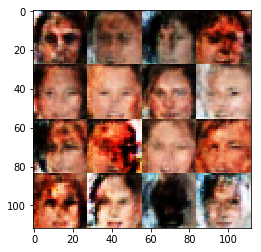

Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 1.1580
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.9739


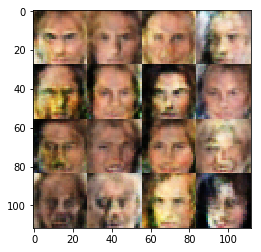

Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 1.0107
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.9078


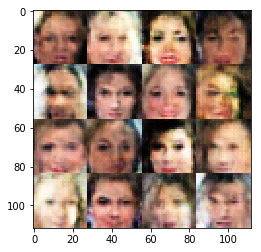

Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.9383


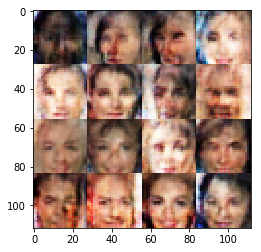

Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.0543


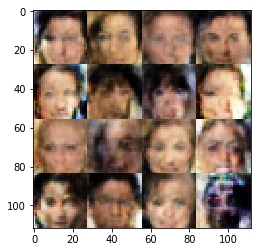

Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8540


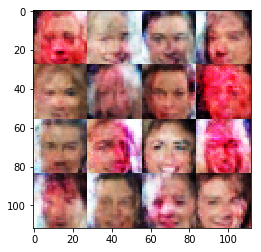

Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7696


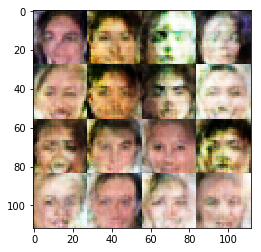

Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8349


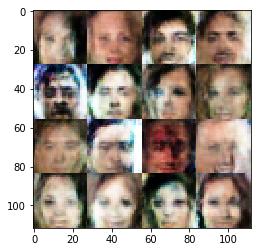

Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.7719


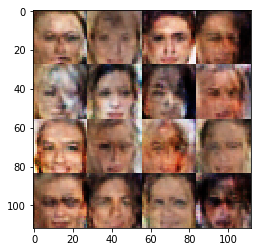

Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9687
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.1424
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.8593


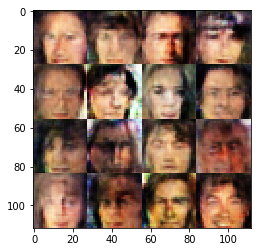

Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.9350


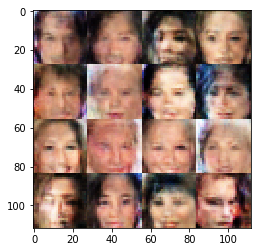

Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.9169


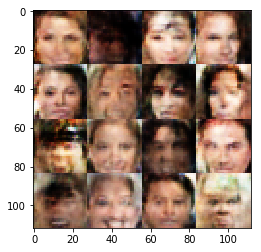

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.7026


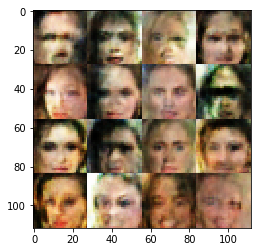

Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 1.0733


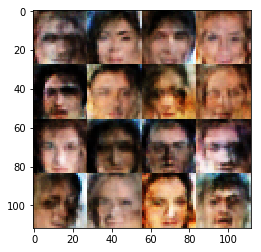

Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.9061


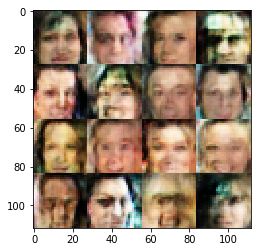

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 1.1496


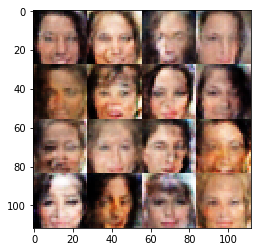

Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8922


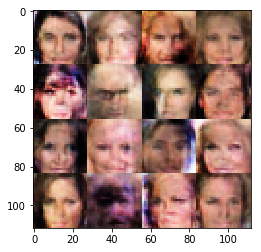

Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.7422


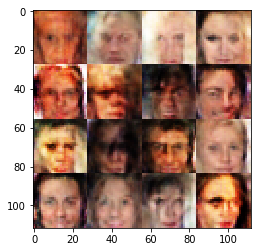

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.6703


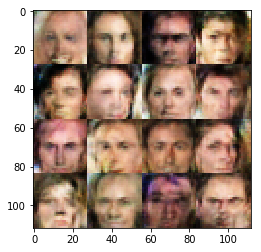

Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8608


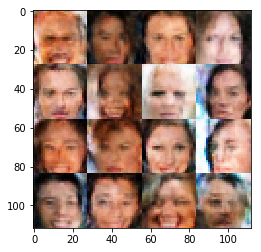

Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7016


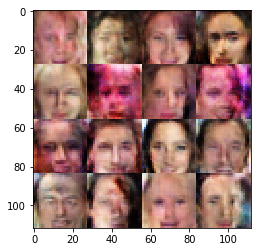

Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 1.0048


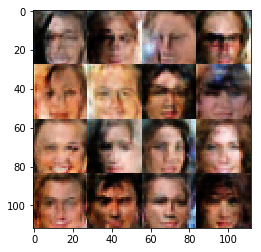

Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8769


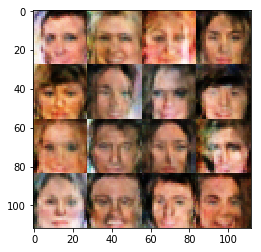

Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.8667


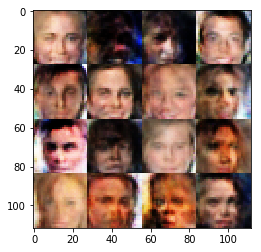

Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.9287


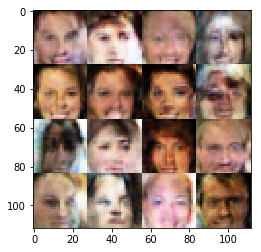

Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.9546


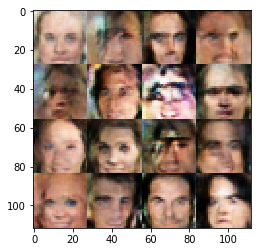

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 1.1003
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7179


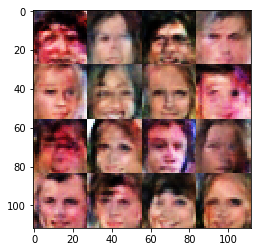

Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 1.1341
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.7628


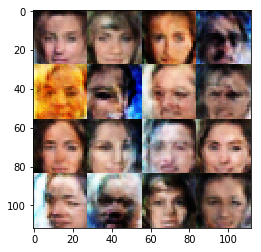

Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.8009


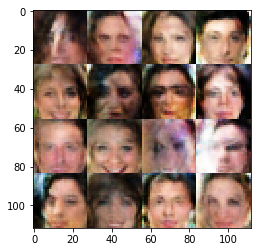

Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.9085


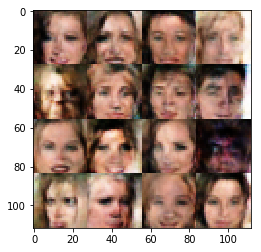

Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8649


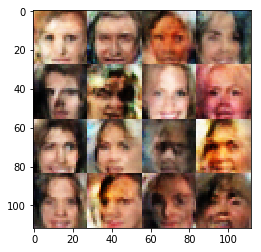

Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7690


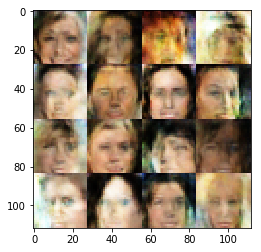

Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 1.0445


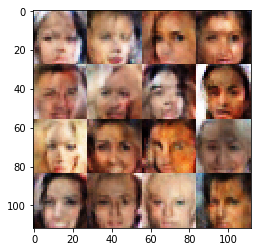

Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.8776


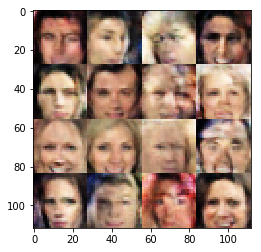

Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 1.0153
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.7536


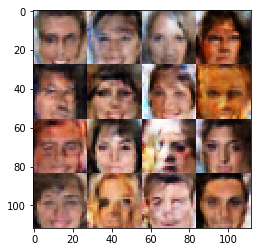

Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7831


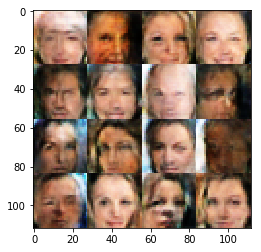

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.7173


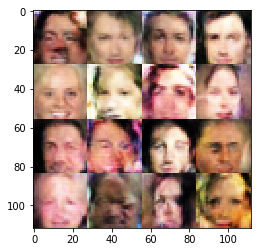

Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8875


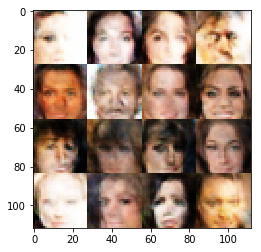

Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.8367


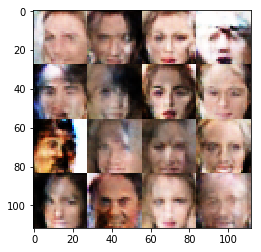

Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.9029


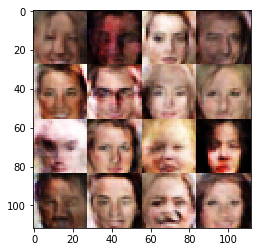

Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.7294


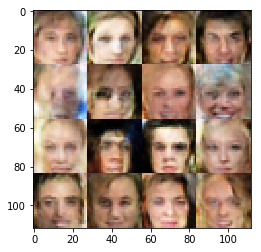

Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.0424


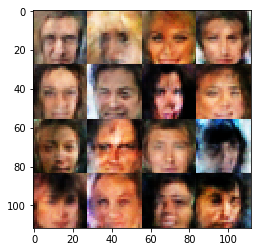

Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 1.0421
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7838


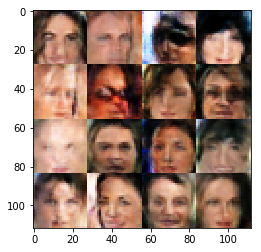

Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.9857
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7664


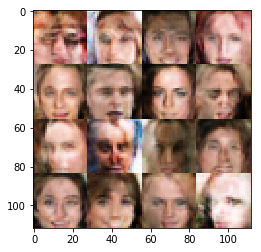

Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8179


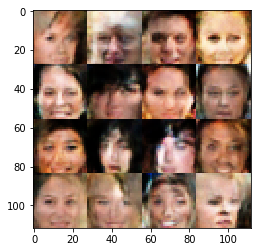

Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.9782


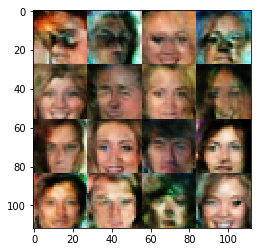

Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.0821
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.9933


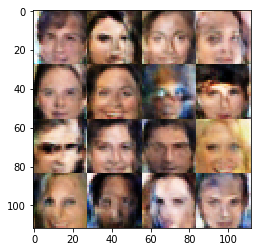

Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.9883
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.1938
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.8611


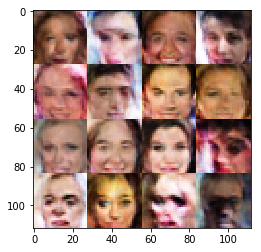

Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7404


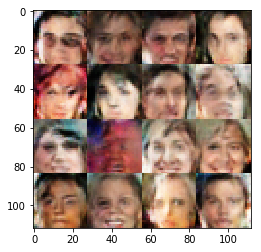

Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.9414


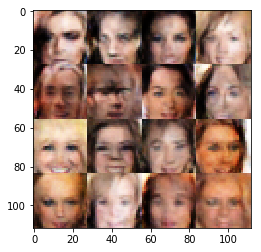

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.8119


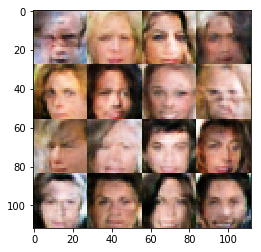

Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 1.2719
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9169


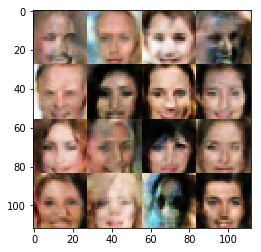

Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.8476


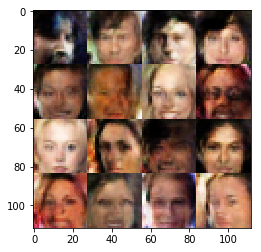

Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 1.0274


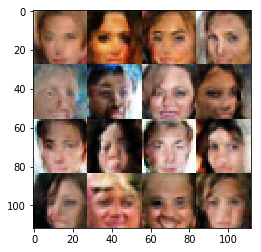

Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.9686


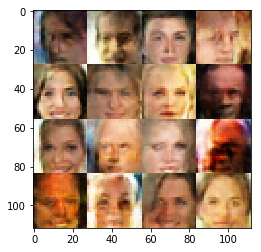

Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.8660


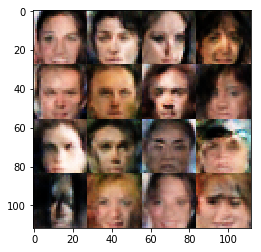

Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.8238


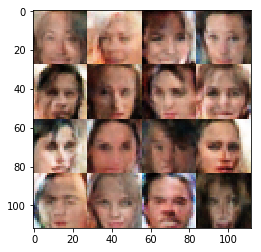

Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.1125
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.1389
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8748


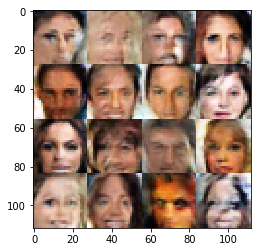

Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.9461


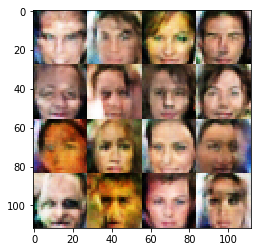

Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.9366


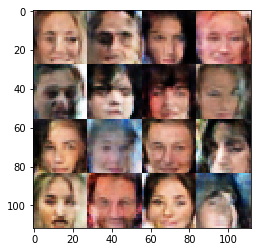

Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.9863
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8091


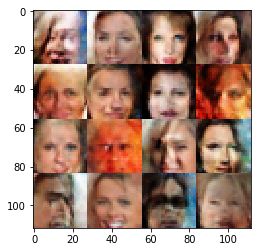

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6313


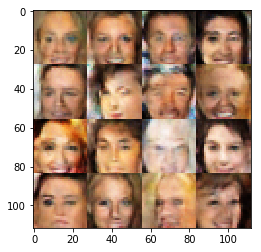

Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8195


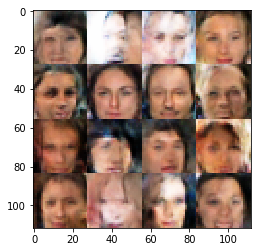

Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 1.1001
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.7144


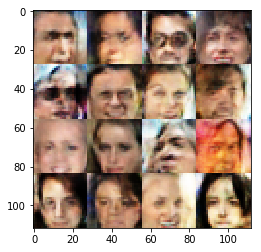

Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.9723


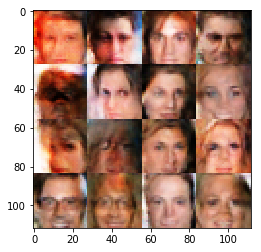

Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.1414


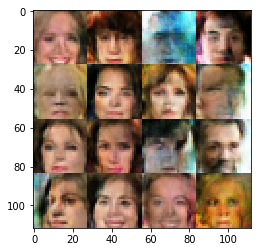

Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.1724


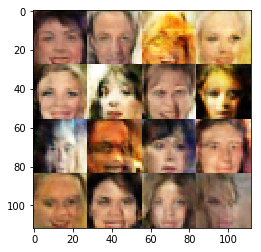

Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.1654


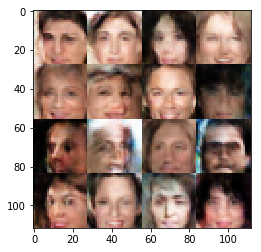

Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.0964
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.9137


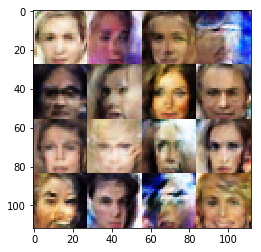

Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.0154


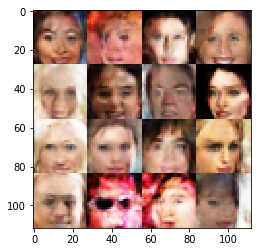

Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.1625
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.1065


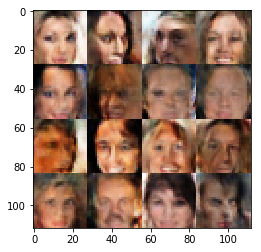

Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.8836


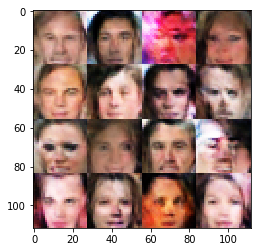

Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 1.1952
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.9490


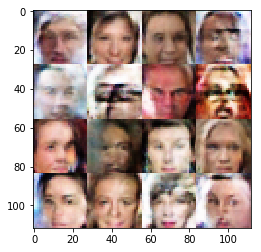

Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.9198


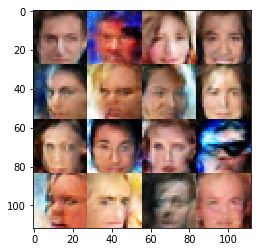

Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 1.1368


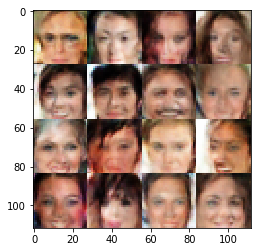

Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.8354


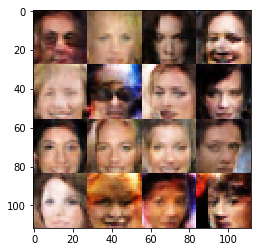

Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.7355


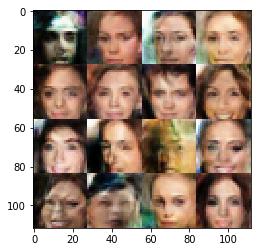

Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8841


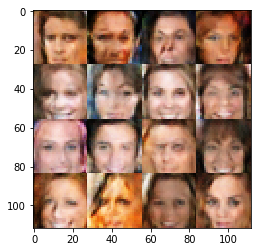

Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 1.3707
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.0992


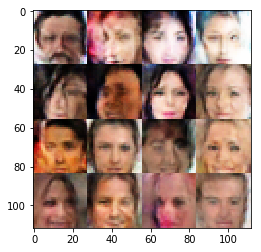

Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 1.0064


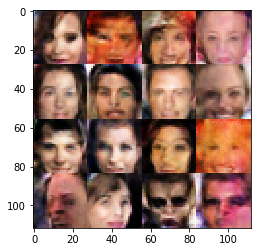

Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 1.1290


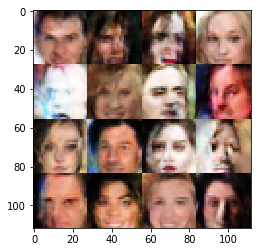

Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.1330


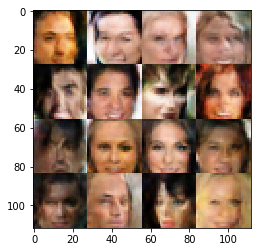

Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 1.0327
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9344


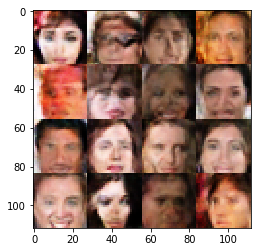

Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.9020


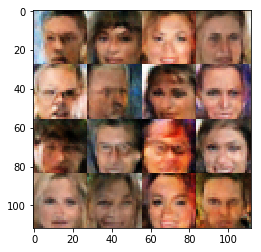

Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.7439


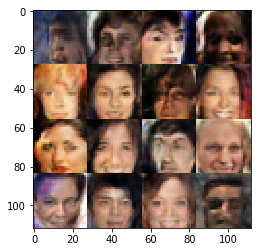

Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.0189


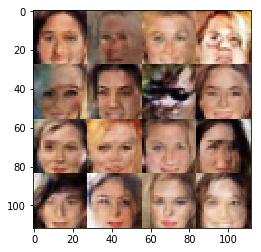

Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.2060
Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 1.2716


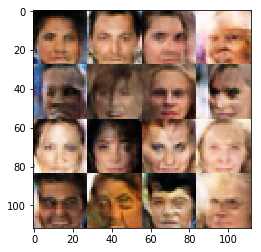

Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.2508
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 0.9827
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.8121


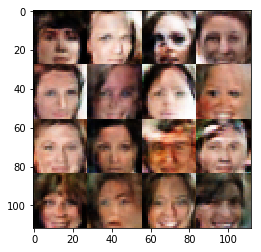

Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.0566


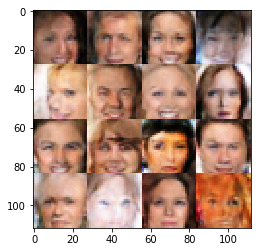

Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8119


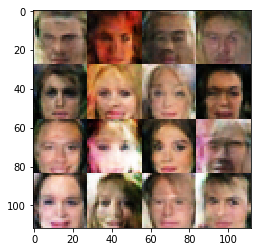

Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.0287
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.2683


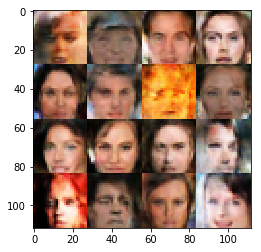

Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 1.4549


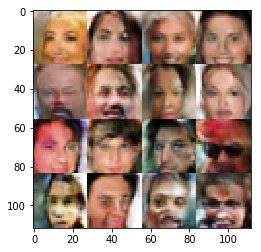

Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.4381
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.8585


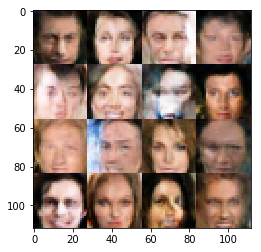

Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.1991
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.9692


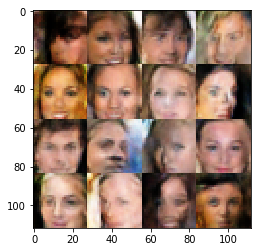

Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.4847
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.4383


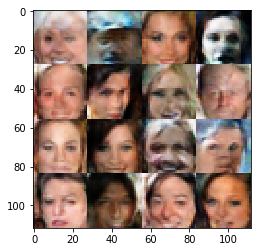

Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.6514


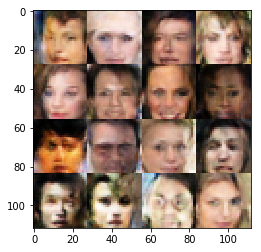

Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.0140
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.0929


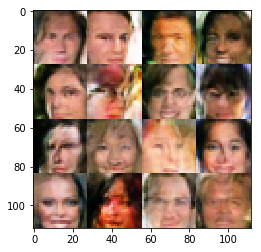

Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 1.3407
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 1.0924


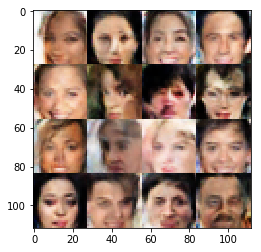

Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.3717
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.3114
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.0398


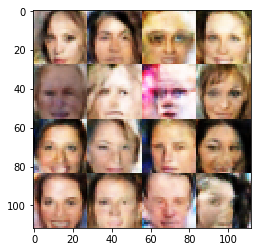

Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.9875


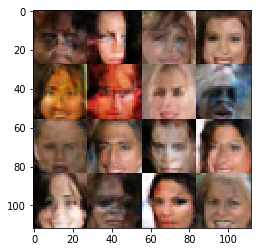

Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.3574
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.1883


In [34]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)